# Face generation with DCGAN

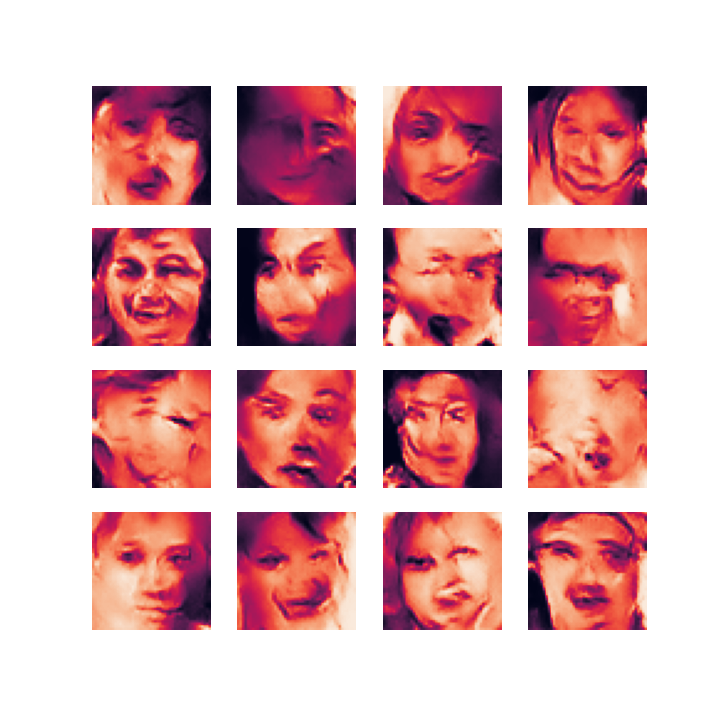

*Figure: Evolution of faces generated in 100 epochs*

## Deep Convolutional Generative Adversarial Network (DCGAN)

A DCGAN is a direct extension of the GAN, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively.  It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. For detailed information, you can refer to the following resources.
* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)
* [Devoloper.google.com](https://developers.google.com/machine-learning/gan/generator)
* [TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)
* [PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


## FER2013 Dataset:

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples. A large amount of data is required for generative adverserial network training. That's why we combined training, testing and validation data. We created a training set of ***35887 images*** in total.

*In this tutorial, new face images will be produced using the  *Facial Expression Recognition (FER2013)* dataset. Since this data set includes different emotional states, the data diversity is quite high. This is positive for GAN training. However, since not all photos are taken from the same angle, the success of face production may be affected.*





## Import modules

In [ ]:
# Let's start importing the necessary python modules.

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape,Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

from IPython import display
print ("tensorflow version: ", tensorflow.__version__ )

For detailed information about [tensorflow and keras libraries](https://www.tensorflow.org/api_docs/python/tf/keras), please go to the link. It contains very useful information for the use of modules.

In [ ]:
#let's check the CPU/GPU devices used and print it to the screen

tensorflow.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## Load datasets

In [ ]:
# Reading dataset with pandas and import to notebook
data= pd.read_csv("../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv") 

# checking data shape
data.shape

In [ ]:
# shows all columns and first 5 rows of dataset
data.head() 

### Data preprocessing

In [ ]:
# In the fer2013 dataset, the pixel values in the "pixels" column were created with spaces between them. let's arrange

x_train_pixels=data.pixels.str.split(" ").tolist()   # We remove the spaces and add the pixel values to the list.
x_train_pixels=pd.DataFrame(x_train_pixels, dtype= int)   # let's convert the pixel list to dataframe

In [ ]:
train_images = x_train_pixels.values #Let's assign the pixel values to a new variable

x_train = train_images.astype(np.float)  #Let's change the type of the variable

print(x_train.shape)  #let's see the variable size

In [ ]:
x_train=x_train.reshape(x_train.shape[0],48,48,1)
x_train.shape

### Visualize

In [ ]:
# show sample images from dataset

plt.figure(figsize=(10,10))
for i in range (16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[np.random.randint(0,35880)] )

plt.show()

## Discriminator

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
# Discriminator Network

def create_discriminator(in_shape=(48,48,1)):
    
    model= Sequential() # create  discriminator model
    
    # 1st convolution layer
    model.add(Conv2D(64,(3,3), strides=(2,2), padding= "same", input_shape= in_shape )) 
    model.add(LeakyReLU(alpha=0.2))
    
    # 2nd convolution layer
    model.add(Conv2D(128,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))
    
    # 3rd convolution layer
    model.add(Conv2D(128,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))
    
    # 4th convolution layer    
    model.add(Conv2D(64,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))

    
    # Full connected layers
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    
    #Optimizer
    opt= Adam(learning_rate= 0.0001, beta_1=0.5)
    
    # Once the model is created, you can config the model with losses and metrics with model.compile()
    model.compile(loss= "binary_crossentropy",
                 optimizer=opt,
                 metrics=["accuracy"])
    
    return model

discriminatorx= create_discriminator()  #Assign the discriminator to a variable to display layers
discriminatorx.summary()

## Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 48x48x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [ ]:
# Generator Network

def create_generator( latent_dim):
    
    model= Sequential() # create generator model
    
    n_nodes=128*6*6 # number of node
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 128)))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))
              
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))
              
    model.add(Conv2D(1, (8,8), activation= "tanh", padding= "same"))
              
    return model
              
generatorx= create_generator(100) # Assign the generator to a variable to display layers
generatorx.summary()

## Deep Convolutional Generative Adversarial Network (DCGAN)

In [ ]:
# Create Generative Adversarial Networks 

def create_gan(generator, discriminator):
    
    discriminator.trainable= False  #stop discriminator training
    
    model= Sequential() # create GAN model
    
    # add generator and discriminator to model
    
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss= "binary_crossentropy",
                 optimizer=Adam(learning_rate= 0.0001, beta_1=0.5))
    
    return model

In [ ]:
# Load training images------> x_train

# normalize pixels to values between -1 and 1 -----> X

def load_real_samples():
    x_train
    X= (x_train.astype("float32")-127.5)/127.5
    
    return X

In [ ]:
# set variable values

# size of the latent space
latent_dim=100

# calling defined functions and creating models.
discriminator =create_discriminator() 
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)

dataset= load_real_samples() # new dataset

In [ ]:
# A random group of images will be selected for gan training
# We assign 1 tag for each real image and 0 tags for fake.

def generate_real_samples(dataset, n_samples): # n_sample---> number of sample images
    
    ix= np.random.randint(0, dataset.shape[0], n_samples)  # choose random samples
    
    X= dataset[ix] 
    
    y= np.ones((n_samples,1)) # let's assign 1 to real examples
    
    return X,y

In [ ]:
# Create latent point

def generate_latent_points(latent_dim, n_samples):

    x_input = np.random.randn(latent_dim * n_samples) # Create latent point

    x_input = x_input.reshape(n_samples, latent_dim) # reshape latent points for input
    return x_input

In [ ]:
# Create fake images

def generate_fake_samples(generator, latent_dim, n_samples):
    
    x_input= generate_latent_points(latent_dim, n_samples) #call the function to create latent points
    
    X= generator.predict(x_input) # Generating new images from latent points
    
    y= np.zeros((n_samples,1)) #assign 0 tags to generated images
    
    return X,y

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions= model(test_input, training=False) # Model training is stopped to infer all layers.

  fig= plt.figure(figsize=(10,10))

  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5*127.5 ) #cmap="binary"
    plt.axis("off")

  plt.savefig("./produced_images_epoch_{:04d}.png".format(epoch)) # save images produced in each epoch
  plt.show()

In [ ]:
n_batch=128 

num_epochs=int(dataset.shape[0]/n_batch)

seed= tensorflow.random.normal(shape=[num_epochs,100])

plt.imshow(seed, cmap="binary")#show seed
plt.axis("off")
plt.title("SEED")

### Model train function


In [ ]:
# train the generator and discriminator

def train (g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128):
    
    batch_per_epoch= int(dataset.shape[0]/n_batch) # How many batches will be created per epoch.
    half_batch= int(n_batch/2) #half of the batches will generate real data in the fake half
    
    for i in range (n_epochs):
        
        for j in range(batch_per_epoch):
            
            # generate images from real dataset,
            X_real, y_real= generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            
            #generate fake images using latent points
            X_fake, y_fake= generate_fake_samples(g_model,latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #generate latent points
            X_gan= generate_latent_points(latent_dim, n_batch)
            y_gan= np.ones((n_batch,1))
            
            g_loss= gan_model.train_on_batch(X_gan, y_gan)

        display.clear_output(wait=True) # clear output on screen
        generate_and_save_images(generator, i+1, seed) # generate, display and save images in new epoch

        print( "epochs: ", i)
    
    display.clear_output(wait=True) # clear output on screen
    generate_and_save_images(generator, i, seed) # generate, display and save images in new epoch
            
    g_model.save("./face_generator.h5") #save network weights

## Training

In [ ]:
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs= 100) 

#### Run this part to show the results as a GIF.

https://www.udemy.com/course/derin-ogrenmeye-giris/learn/lecture/20317005#questions

https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

In [ ]:
import imageio
import glob

anim_file = './dcgan_face.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./produced_images_epoch_*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())

## Reference
 
* https://github.com/bnsreenu/python_for_microscopists/blob/master/248_keras_implementation_of_GAN/248-cifar_GAN.py

* https://github.com/ayyucekizrak/GAN_UreticiCekismeliAglar_ile_SentetikVeriUretme

* https://www.tensorflow.org/tutorials/generative/dcgan

**Prepared by Nurullah Yuksel**